In [41]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [42]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jun 23 07:38:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    39W / 300W |    457MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [43]:
from psutil import virtual_memory

ram = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM.'.format(ram))
if ram < 20:
    print('To enable a high-RAM runtime, select the Runtime > "Change runtime type", then select High-RAM in the Runtime shape dropdown '
          'and then re-execute this cell.')
else:
    print('You are using a high-RAM runtime.')

Your runtime has 27.3 gigabytes of available RAM.
You are using a high-RAM runtime.


In [44]:
from tensorflow import config

physical_devices = config.list_physical_devices('GPU')
try:
    config.experimental.set_memory_growth(physical_devices[0], True)
except Exception as exception:
    print(exception)

In [45]:
from keras.utils.vis_utils import plot_model
from tensorflow import device
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import optimizers

import csv
import datetime
import gc
import h5py
import numpy as np
import os
import re

In [46]:
town = 'Berlin'  #@param ['Berlin', 'Istanbul', 'Moscow']

files = '/content/gdrive/My Drive/Licenta/Traffic4Cast/{}/files/training'.format(town)
checkpoints = '/content/gdrive/My Drive/Licenta/Traffic4Cast/{}/checkpoints/seq2seq3'.format(town)
logs = '/content/gdrive/My Drive/Licenta/Traffic4Cast/{}/logs/seq2seq3/training/logs.csv'.format(town)

In [47]:
def get_date(file_name):
    match = re.search(r'\d{4}-\d{2}-\d{2}', file_name)
    return datetime.datetime.strptime(match.group(), '%Y-%m-%d').date()

In [48]:
def get_file_names(files, excluded_dates=[]):
    file_names = os.listdir(files)
    np.random.shuffle(file_names)
    excluded_dates = [datetime.datetime.strptime(excluded_date, '%Y-%m-%d').date() for excluded_date in excluded_dates]
    file_names = [file_name for file_name in file_names if get_date(file_name) not in excluded_dates]
    return file_names[:45]

In [49]:
def load_data(file_path):
    file = h5py.File(file_path, 'r')
    group_key = list(file.keys())[0]
    data = np.array(file[group_key][:], dtype=np.float32)
    file.close()
    data = np.take(data, np.arange(8), axis=-1)  # keep only the dynamic channels
    data = np.array(np.split(data, 48))  # 48 * (3 + 3) = 288
    data = np.moveaxis(data, -1, 2)  # transpose to (batches, timestamps, channels, rows, columns)
    np.random.shuffle(data)  # shuffle the 48 batches
    return data / 255.0

In [50]:
def get_model():
    inputs = layers.Input(shape=(3, 8, 495, 436), name='inputs')

    conv_lstm_0 = layers.ConvLSTM2D(filters=32, kernel_size=(6, 6), padding='same', return_sequences=True,
                                    return_state=False, activation='tanh', recurrent_activation='hard_sigmoid',
                                    kernel_initializer='glorot_uniform', unit_forget_bias=True,
                                    data_format='channels_first', name='conv_lstm_0')

    conv_lstm_1 = layers.ConvLSTM2D(filters=48, kernel_size=(6, 6), padding='same', return_sequences=False,
                                    return_state=True, activation='tanh', recurrent_activation='hard_sigmoid',
                                    kernel_initializer='glorot_uniform', unit_forget_bias=True,
                                    data_format='channels_first', name='conv_lstm_1')

    conv_lstm_2 = layers.ConvLSTM2D(filters=48, kernel_size=(6, 6), padding='same', return_sequences=True,
                                    return_state=False, activation='tanh', recurrent_activation='hard_sigmoid',
                                    kernel_initializer='glorot_uniform', unit_forget_bias=True,
                                    data_format='channels_first', name='conv_lstm_2')

    conv_lstm_3 = layers.ConvLSTM2D(filters=8, kernel_size=(6, 6), padding='same', return_sequences=True,
                                    return_state=False, activation='tanh', recurrent_activation='hard_sigmoid',
                                    kernel_initializer='glorot_uniform', unit_forget_bias=True,
                                    data_format='channels_first', name='conv_lstm_3')

    # encoder
    outputs = conv_lstm_0(inputs)
    outputs = conv_lstm_1(outputs)[-1]

    outputs = layers.Flatten(name='flatten')(outputs)
    outputs = layers.RepeatVector(3, name='repeat_vector')(outputs)
    outputs = layers.Reshape((3, 48, 495, 436), name='reshape')(outputs)

    # decoder
    outputs = conv_lstm_2(outputs)
    outputs = conv_lstm_3(outputs)

    return models.Model(inputs=inputs, outputs=outputs)

In [51]:
with device('gpu:0'):
    model = get_model()
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0003), loss=losses.mean_squared_error)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 3, 8, 495, 436)]  0         
_________________________________________________________________
conv_lstm_0 (ConvLSTM2D)     (None, 3, 32, 495, 436)   184448    
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     [(None, 48, 495, 436), (N 553152    
_________________________________________________________________
flatten (Flatten)            (None, 10359360)          0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 3, 10359360)       0         
_________________________________________________________________
reshape (Reshape)            (None, 3, 48, 495, 436)   0         
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 3, 48, 495, 436)   6637

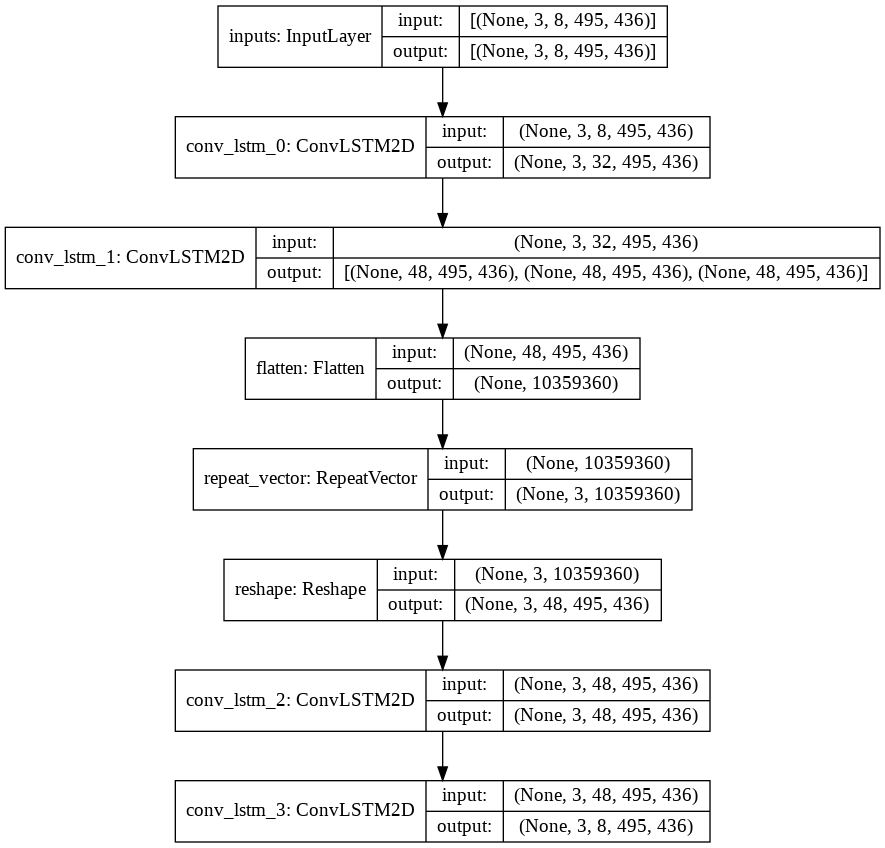

In [52]:
plot_model(model, to_file='seq2seq3.png', show_shapes=True, show_layer_names=True)

In [ ]:
log_file = open(logs, 'w', newline='')
log_writer = csv.writer(log_file)
log_writer.writerow(['epoch', 'file', 'loss'])
log_file.flush()

In [ ]:
for epoch in range(4):
    print('epoch:', epoch)
    file_names = get_file_names(files)
    for index, file_name in enumerate(file_names):
        print('file:', index)
        data = load_data(os.path.join(files, file_name))
        inputs = data[:, :3]
        outputs = data[:, 3:]
        with device('gpu:0'):
            history = model.fit(inputs, outputs, epochs=1, batch_size=3)
        log_writer.writerow([epoch, file_name, history.history['loss'][0]])
        log_file.flush()
        gc.collect()
    model.save(os.path.join(checkpoints, 'model_{}.h5'.format(epoch)))

In [ ]:
log_file.close()